# Imports

In [1]:
import sys
sys.path.insert(1, '../')
from genesis import *

C:\Users\vin_s\AppData\Local\Programs\Python\Python39\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
# pd.options.display.max_rows = 300

In [3]:
universe = ASIA_FX
total_returns = total_returns_usd[universe]
spot_returns = spot_returns_usd[universe]
carry_returns = carry_returns_usd[universe]

# Settings

In [4]:
s = Settings(start_date = "2000-01-01", end_date = "2016-12-31", notional = 100, implementation_lag = 1,
             asset_scaling_method="simple", asset_scaling_target=0.1, asset_scaling_width=130,
             sector_scaling_method="simple", sector_scaling_target=0.1, sector_scaling_width=130,
             portfolio_scaling_method="simple", portfolio_scaling_target=0.1, portfolio_scaling_width=260)

# Other Data

In [5]:
neer = read_prices("../../Dymon/Code Data/NEER.csv")

In [6]:
neer.columns = [x[0] for x in neer.columns]

In [8]:
asia_neer = neer[[("JBDN"+x+" Index") for x in ["SGD", "THB", "TWD", "KRW", "PHP", "INR", "IDR", "CNY"]]]
asia_neer.columns = ["USD"+x for x in ["SGD", "THB", "TWD", "KRW", "PHP", "INR", "IDR", "CNH"]]
asia_neer_cleaned = asia_neer.pipe(fill_date).pipe(omit_trailing_na).ffill()
asia_neer_cleaned.loc[:,"USDMYR"] = pd.Series(np.nan)

# Signal 

In [9]:
def band_filter(series):
  return series.applymap(lambda x: -x if abs(x) > 1.5 else 0)

def hold_until_flip(series):
  ser = pd.DataFrame(series)
  ser.columns = ["ccy"]
  ser["shift"] = ser.shift(1)
  ser["sign_change"] = ser.apply(lambda row: 1 if abs(row["ccy"]) > 1.5 else 0, axis=1)
  ser["sign_change"] = ser.apply(lambda row: 1 if row["sign_change"] == 1 else np.nan if pd.isna(row["ccy"]) else 4 if np.sign(row["ccy"]) != np.sign(row["shift"]) else 0 , axis=1)
  ser["signal"] = ser[["ccy"]].pipe(band_filter)
  ser['sign_forward']=ser['sign_change'].replace(0, np.NaN).ffill()
  ser['sign_shift'] = ser['sign_forward'].diff().replace(0, np.NaN)
  ser["signal"] = ser.apply(lambda row: np.nan if pd.isna(row["sign_shift"]) else row["signal"], axis=1).ffill()
  
  return ser["signal"]

In [10]:
sig = asia_neer_cleaned.ffill().pct_change().pipe(zscore, 252*5, 252*3).apply(hold_until_flip) * -1

In [11]:
sig = sig.pipe(demean_xs).pipe(top_bottom_xs)
sig[abs(sig) < 0.25] = 0
sig = CAP(sig, 2.5)

In [12]:
b = Backtest(signal = sig, asset_returns = total_returns, tcost = abs(total_returns*0), settings = s)
b.run()

Re-arranging asset columns
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]


In [13]:
bt_obj = b

In [14]:
get_summary(bt_obj)

Returns   : 0.0070307558984589
Vol       : 0.11284826912081411
SR        : 0.06230273581716925
Max DD    : -33.55
Hit rate  : 0.505
W | N | L : 0.33 | 0.35 | 0.32
W/L Ratio : 1.02


In [15]:
get_returns_stats(bt_obj.asset_rtn, b.wts)

C:\Users\vin_s\National University of Singapore\FSP Dymon AY21 22 Term 1 - Documents\Codebase\02_Value\..\genesis.py:515: RuntimeWarning: invalid value encountered in double_scalars
  return (ret - rf).mean() * np.sqrt(obs_per_year) / ret.std()
C:\Users\vin_s\National University of Singapore\FSP Dymon AY21 22 Term 1 - Documents\Codebase\02_Value\..\genesis.py:519: RuntimeWarning: invalid value encountered in double_scalars
  return (dollar_ret - rf).mean() * np.sqrt(obs_per_year) / dollar_ret.std()


,USDSGD,USDTHB,USDTWD,USDKRW,USDPHP,USDINR,USDIDR,USDMYR,USDCNH
annualized_return,0.848114,-0.561478,0.797617,-0.822556,0.594063,-0.11689,0.797747,0.0,-0.975265
sharpe,0.251056,-0.12199,0.240852,-0.213988,0.17107,-0.023825,0.221347,NaN,-0.444584
dollar_sharpe,0.219971,-0.140367,0.227032,-0.242683,0.14728,-0.049033,0.216408,NaN,-0.453818
trade_sharpe,-0.28906,-0.467587,0.092747,-0.540753,0.297603,-0.462425,0.234334,NaN,-0.125517
long_sharpe,0.930718,-0.296227,-1.502386,0.548423,0.155627,-1.342443,0.177166,NaN,0.6759
short_sharpe,-0.737174,-1.042202,1.027367,-1.395249,0.683535,0.056623,0.597843,NaN,-4.060008
sortino,0.072346,-0.031271,0.064987,-0.044446,0.038524,-0.004746,0.038882,NaN,-0.085884
max_drawdown,-16.506977,-24.995765,-13.217486,-21.465713,-9.606534,-22.50579,-15.322417,0.0,-21.936495
max_drawdown_start,2011-09-07,2006-12-21,2011-02-14,2003-08-22,2015-06-05,2004-03-25,2005-09-14,2016-12-30,2011-09-26
max_drawdown_end,2015-04-03,2016-09-09,2015-01-27,2011-09-22,2016-12-30,2004-05-06,2011-09-28,2016-12-30,2016-11-11


C:\Users\vin_s\National University of Singapore\FSP Dymon AY21 22 Term 1 - Documents\Codebase\02_Value\..\genesis.py:578: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  returns = returns.drop([i],1)


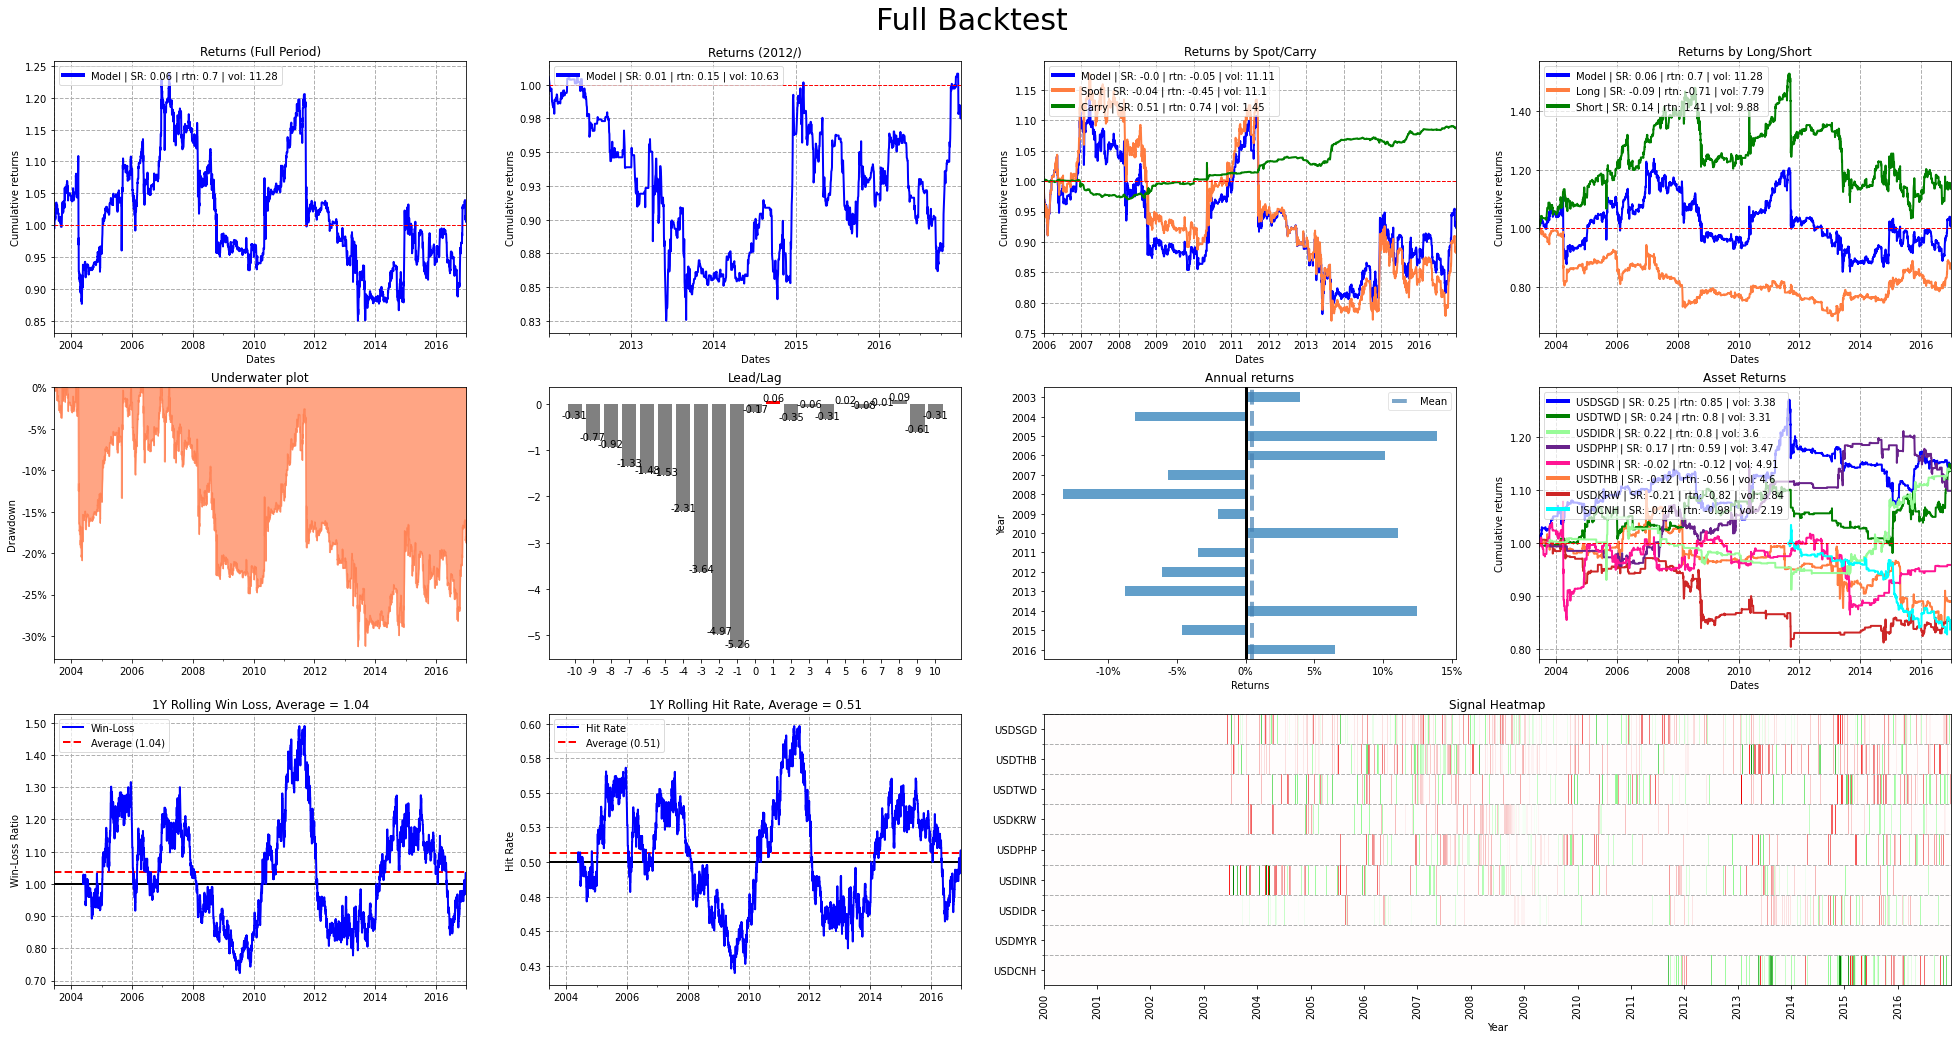

In [16]:
plot_bt(bt_obj)

In [ ]:
pf.plot_monthly_returns_dist(bt_obj.model_rtn)

In [ ]:
gs = GridSpec(nrows = 2, ncols = 2)
fig = plt.figure(figsize=(20, 15))
fig.suptitle(t="Full Backtest", fontsize=30, y=.925)

fig.add_subplot(gs[0]).set_label(gen_plot_rtn(bt_obj.model_rtn, main = "Returns (Full Period)"))
fig.add_subplot(gs[1]).set_label(gen_rtn_asset(bt_obj))
fig.add_subplot(gs[2]).set_label(pf.plot_drawdown_underwater(bt_obj.model_rtn))
fig.add_subplot(gs[3]).set_label(gen_rtn_longshort(bt_obj))

In [ ]:
# gen_rtn_longshort(bt_obj)
# gen_rtn_component(bt_obj, spot_rtns, carry_rtns)
# gen_leadlag(b, nlag=20)
# gen_rolling_hitrate(bt_obj.model_rtn)
# gen_rolling_winloss(bt_obj.model_rtn)
# pf.plot_monthly_returns_dist(bt_obj.model_rtn)
# pf.plot_annual_returns(bt_obj.model_rtn)
# gen_signal(bt_obj)
# gen_rtn_asset(bt_obj)
# gen_plot_rtn(bt_obj.model_rtn["2012":])
# gen_rolling_sharpe(bt_obj.model_rtn)
# gen_rtn_col_component(bt_obj, spot_rtns, carry_rtns)
# gen_rtn_col_longshort(bt_obj)

In [ ]:
def band_filter(series):
  return series.applymap(lambda x: 1 if x < -1.5 else -1 if x > 1.5 else 0)

def hold_position(series):
  tmp = np.sign(series).diff()
  return pd.Series([np.nan if y == 0 else x for x,y in zip(series, tmp.diff())], index = tmp.index).ffill()

binary = spot_returns.pipe(zscore, 252*5).pipe(band_filter)
mag = abs(spot_returns.pipe(zscore, 252*5)) * binary
sig = mag.apply(hold_position)